# Random  Forest on Amazon Fine Food reviews

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords
from gensim.models import Word2Vec

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from sklearn.model_selection import train_test_split



import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
con = sqlite3.connect('database.sqlite')

In [3]:
filtered_data=pd.read_sql_query("""Select * FROM Reviews WHERE Score !=3 LIMIT 5000 """,con)

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (5000, 10)


In [8]:
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort', na_position='last')

In [9]:
type(sorted_data)

pandas.core.frame.DataFrame

In [10]:
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)

In [11]:
len(final)

4986

In [12]:
display = pd.read_sql_query("""Select * From Reviews Where Score!=3 and HelpfulnessNumerator > HelpfulnessDenominator""",con)

In [13]:
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
print(final.shape)

(4986, 10)


In [16]:
sent_0 = final['Text'].values[0]
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
#Removing html tags

In [18]:
import re
sent_0 = re.sub(r"http\S+", "", sent_0)

In [19]:
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
soup = BeautifulSoup(sent_0, 'lxml')

In [21]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
from tqdm import tqdm

preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1427.22it/s]


In [24]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [25]:
filtered_data.shape

(5000, 10)

In [26]:
# Adding preprocessed text to the original dataframe

In [27]:
final['preprocessed reviews'] = preprocessed_reviews

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed reviews
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...


In [29]:
final['Score'].value_counts()

1    4178
0     808
Name: Score, dtype: int64

### Applying Train test split

In [30]:
X = final['preprocessed reviews']
Y = final['Score']

In [31]:
print(X.shape,Y.shape)

(4986,) (4986,)


In [32]:
x_tr,x_test,y_tr,y_test = train_test_split(X,Y,test_size=0.3)

In [33]:
print(x_tr.shape,x_test.shape,y_tr.shape,y_test.shape)

(3490,) (1496,) (3490,) (1496,)


## 1.Bag of Words- Unigrams

In [34]:
bow = CountVectorizer()
x_tr_uni = bow.fit_transform(x_tr)
x_test_uni= bow.transform(x_test)

###  Finding the optimal nEstimator & depth using gridsearch

Fitting 5 folds for each of 272 candidates, totalling 1360 fits
Best HyperParameter:  {'max_depth': 140, 'n_estimators': 8}
0.8447372521286105


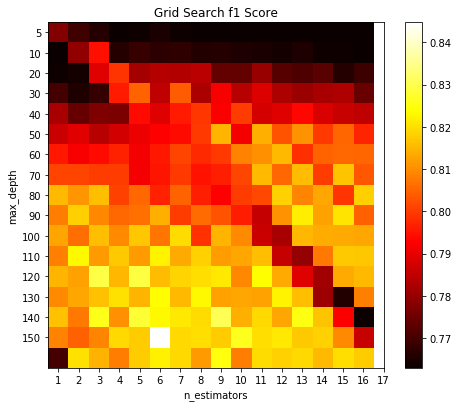

In [35]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_uni,y_tr)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)

plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

### Finding the accuracy,F1-score in Test data using optimal nEstimator & depth

Accuracy on test set: 83.556%
Precision on test set: 0.671
Recall on test set: 0.592
F1-Score on test set: 0.610


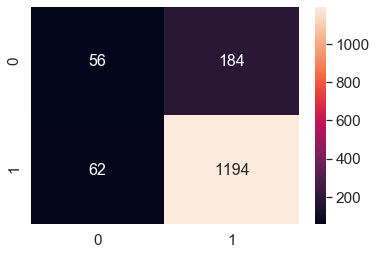

In [36]:
RF= RandomForestClassifier(n_estimators=8,max_depth=140)
RF.fit(x_tr_uni,y_tr)
y_pred =RF.predict(x_test_uni)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Finding the optimal nEstimator & depth using RandomSearchCv

In [38]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = {'n_estimators':nEstimator,'max_depth': depth}
gsv = RandomizedSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted')
gsv.fit(x_tr_uni,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best HyperParameter:  {'n_estimators': 16, 'max_depth': 130}
0.8284355259253712


### Finding the accuracy,F1-score in Test data using optimal nEstimator & depth

Accuracy on test set: 85.561%
Precision on test set: 0.753
Recall on test set: 0.604
F1-Score on test set: 0.630


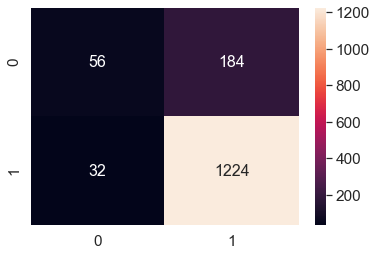

In [39]:
RF= RandomForestClassifier(n_estimators=16,max_depth=130)
RF.fit(x_tr_uni,y_tr)
y_pred =RF.predict(x_test_uni)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [40]:
dic = pd.DataFrame(gsv.cv_results_) 
dic

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.113479,0.011812,0.003207,0.002643,2,140,"{'n_estimators': 2, 'max_depth': 140}",0.774040,0.780455,0.776982,0.766396,0.782758,0.776126,0.005701,10
1,0.058907,0.004412,0.002001,0.002531,2,40,"{'n_estimators': 2, 'max_depth': 40}",0.786910,0.790657,0.785514,0.784587,0.783402,0.786214,0.002501,9
2,0.471160,0.011964,0.009381,0.007659,12,80,"{'n_estimators': 12, 'max_depth': 80}",0.808267,0.817047,0.820391,0.819057,0.811961,0.815345,0.004554,4
3,0.504807,0.028793,0.015637,0.000002,10,130,"{'n_estimators': 10, 'max_depth': 130}",0.851109,0.813872,0.821362,0.795848,0.825830,0.821604,0.017953,3
4,0.259023,0.007380,0.003125,0.006251,5,150,"{'n_estimators': 5, 'max_depth': 150}",0.812210,0.815688,0.805202,0.808341,0.795803,0.807449,0.006812,5
5,0.648606,0.029764,0.013053,0.006585,15,80,"{'n_estimators': 15, 'max_depth': 80}",0.826989,0.798772,0.790160,0.798682,0.822535,0.807428,0.014563,6
6,0.857737,0.036377,0.006122,0.007501,16,130,"{'n_estimators': 16, 'max_depth': 130}",0.829598,0.835174,0.829897,0.808203,0.839306,0.828436,0.010737,1
7,0.487503,0.011703,0.009379,0.007658,17,50,"{'n_estimators': 17, 'max_depth': 50}",0.802515,0.772891,0.807747,0.784068,0.786712,0.790786,0.012706,8
8,0.431248,0.007663,0.009376,0.007655,15,50,"{'n_estimators': 15, 'max_depth': 50}",0.814103,0.778524,0.798682,0.795740,0.790018,0.795413,0.011614,7
9,0.912042,0.225760,0.015052,0.001083,14,140,"{'n_estimators': 14, 'max_depth': 140}",0.825626,0.821565,0.835850,0.821125,0.829048,0.826643,0.005437,2


## Feature Importance

In [44]:
RF= RandomForestClassifier(n_estimators=16,max_depth=130)
RF.fit(x_tr_uni,y_tr)

RandomForestClassifier(max_depth=130, n_estimators=16)

In [45]:
features=(-RF.feature_importances_).argsort()
print(np.take(bow.get_feature_names(), features))

['not' 'great' 'awful' ... 'growing' 'grounds' 'zucchini']


## Bi-Grams


In [47]:
bi_gram = CountVectorizer(ngram_range=(1,2))
x_tr_bi = bi_gram.fit_transform(x_tr)
x_test_bi = bi_gram.transform(x_test)

### Finding the optimal nEstimator & depth  using gridsearchcv

Fitting 5 folds for each of 272 candidates, totalling 1360 fits
Best HyperParameter:  {'max_depth': 150, 'n_estimators': 6}
0.8193239617903456


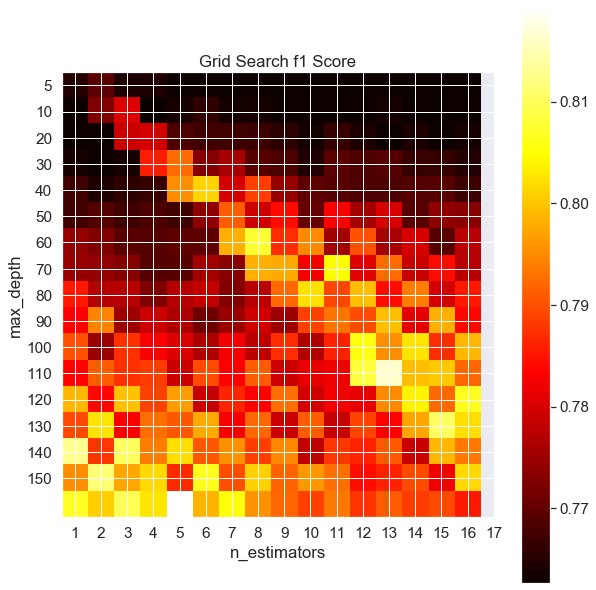

In [48]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

### Finding the accuracy in Test data using optimal nEstimator & depth

Accuracy on test set: 85.963%
Precision on test set: 0.776
Recall on test set: 0.606
F1-Score on test set: 0.635


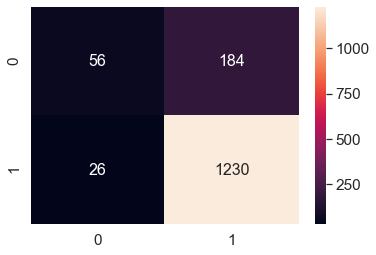

In [49]:
RF= RandomForestClassifier(n_estimators=6,max_depth=150)
RF.fit(x_tr_bi,y_tr)
y_pred =RF.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Finding the optimal nEstimator & depth using RandomSearchCv

In [50]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = {'n_estimators':nEstimator,'max_depth': depth}
gsv = RandomizedSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_bi,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best HyperParameter:  {'n_estimators': 4, 'max_depth': 130}
0.8087426306130782


### Finding the accuracy in Test data using optimal C

Accuracy on test set: 82.888%
Precision on test set: 0.640
Recall on test set: 0.566
F1-Score on test set: 0.577


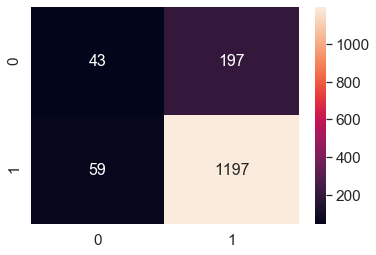

In [51]:
RF= RandomForestClassifier(n_estimators=4,max_depth=130)
RF.fit(x_tr_bi,y_tr)
y_pred =RF.predict(x_test_bi)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Feature Importance

In [55]:
RF= RandomForestClassifier(n_estimators=4,max_depth=130)
RF.fit(x_tr_bi,y_tr)

RandomForestClassifier(max_depth=130, n_estimators=4)

In [56]:
features=(-RF.feature_importances_).argsort()
print(np.take(bi_gram.get_feature_names(), features))

['return' 'disappointing' 'awful' ... 'food afghans' 'food adult'
 'zucchini update']


## TF-IDF

In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_tr_tfidf = tf_idf_vect.fit_transform(x_tr)
x_test_tfidf = tf_idf_vect.transform(x_test)

### Finding the optimal nEstimator & depth using GridsearchCv

Fitting 5 folds for each of 272 candidates, totalling 1360 fits
Best HyperParameter:  {'max_depth': 150, 'n_estimators': 4}
0.8189649315361993


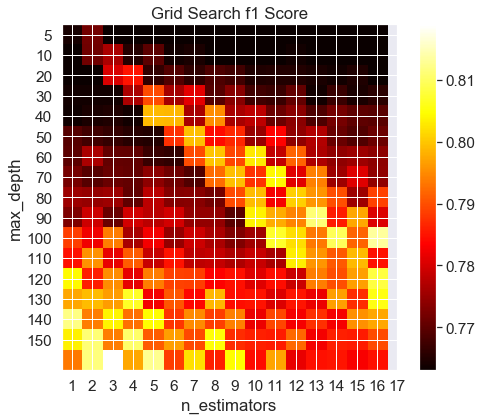

In [63]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tfidf,y_tr)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

## Finding the accuracy in Test data using optimal nEstimator & depth

Accuracy on test set: 82.420%
Precision on test set: 0.642
Recall on test set: 0.589
F1-Score on test set: 0.603


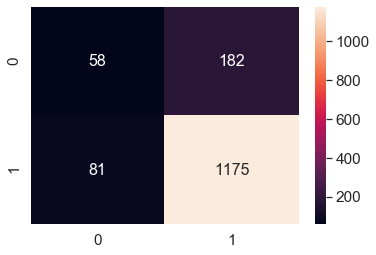

In [64]:
RF= RandomForestClassifier(n_estimators=4,max_depth=150)
RF.fit(x_tr_tfidf,y_tr)
y_pred =RF.predict(x_test_tfidf)

print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))

sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Finding the optimal nEstimator & depth using RandomSearchCv

In [65]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = {'n_estimators':nEstimator,'max_depth': depth}
gsv = RandomizedSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_tfidf,y_tr)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best HyperParameter:  {'n_estimators': 2, 'max_depth': 150}
0.7974666300461931


### Finding the accuracy,F1-score in Test data using optimal nEstimator & depth

Accuracy on test set: 76.270%
Precision on test set: 0.605
Recall on test set: 0.633
F1-Score on test set: 0.614


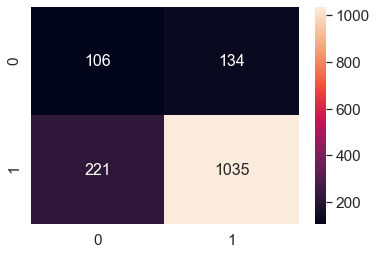

In [69]:
RF= RandomForestClassifier(n_estimators=2,max_depth=150)
RF.fit(x_tr_tfidf,y_tr)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Feature Importance

In [71]:
RF= RandomForestClassifier(n_estimators=4,max_depth=150)
RF.fit(x_tr_tfidf,y_tr)

RandomForestClassifier(max_depth=150, n_estimators=4)

In [72]:
features=(-RF.feature_importances_).argsort()
print(np.take(tf_idf_vect.get_feature_names(), features))

['return' 'disappointed' 'not buy' ... 'following whole'
 'following southern' 'zucchini update']


## Word2Vec

In [73]:
i=0
list_of_sent=[]
for sent in x_tr:
    list_of_sent.append(sent.split())
i=0
list_of_sent_test=[]
for sent in x_test:
    list_of_sent_test.append(sent.split())

In [74]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [75]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3093
sample words  ['received', 'gift', 'box', 'contained', 'stonewall', 'farms', 'pancake', 'mix', 'world', 'fluffy', 'flavorful', 'pancakes', 'waffles', 'ever', 'taste', 'price', 'amazon', 'big', 'savings', 'ordering', 'not', 'away', 'larger', 'size', 'two', 'pack', 'no', 'time', 'best', 'add', 'hot', 'water', 'yummy', 'anything', 'even', 'cream', 'sauces', 'soups', 'sausage', 'heaven', 'yum', 'cannot', 'go', 'wrong', 'product', 'us', 'made', 'version', 'chocolate', 'distinct']


## Avg W2V

In [76]:
sent_vectors = []
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

3490
50


In [77]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

1496
50


In [78]:
x_test_av1=sent_vectors_test
x_tr_av1=sent_vectors

### Finding the optimal nEstimator & depth using GridSearchcv 

Fitting 5 folds for each of 272 candidates, totalling 1360 fits
Best HyperParameter:  {'max_depth': 20, 'n_estimators': 10}
0.7870870336372209


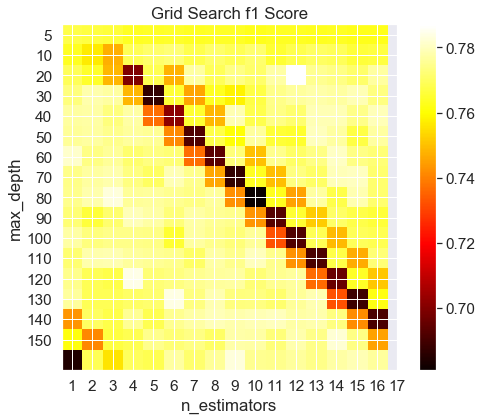

In [79]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]

gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search f1 Score')
plt.show()

### Finding the accuracy,f1-score in Test data using optimal nEstimator & depth

Accuracy on test set: 83.957%
Precision on test set: 0.420
Recall on test set: 0.500
F1-Score on test set: 0.456


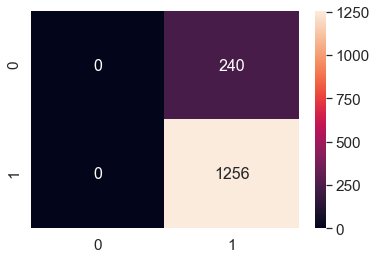

In [82]:
RF= RandomForestClassifier(n_estimators=20,max_depth=10)
RF.fit(x_tr_tfidf,y_tr)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Finding the optimal nEstimator & depth using RandomSearchCv

In [83]:
nEstimator = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
depth = [5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

RF = RandomForestClassifier()
hyperParam = {'n_estimators':nEstimator,'max_depth': depth}
gsv = RandomizedSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='f1_weighted',n_jobs=-1)
gsv.fit(x_tr_av1,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best HyperParameter:  {'n_estimators': 17, 'max_depth': 60}
0.7810942421218311


### Finding the optimal nEstimator & depth using GridSearch

Accuracy on test set: 84.559%
Precision on test set: 0.877
Recall on test set: 0.520
F1-Score on test set: 0.498


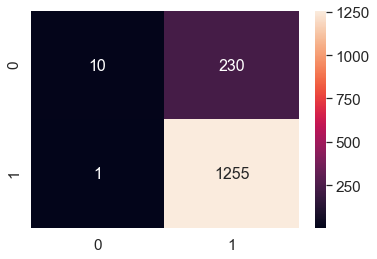

In [84]:
RF= RandomForestClassifier(n_estimators=17,max_depth=60)
RF.fit(x_tr_tfidf,y_tr)
y_pred =RF.predict(x_test_tfidf)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average='macro')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average='macro')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')